In [1]:
import pandas as pd
import numpy as np
import hail as hl
import os.path as osp
import multiprocessing

# Benchmarking utilities
%run ../init/benchmark.py
register_timeop_magic(get_ipython(), 'hail')

data_dir = osp.expanduser('~/data/gwas/tutorial/1_QC_GWAS')
hl.init() 

Running on Apache Spark version 2.4.4
SparkUI available at http://3d498b83ee57:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/tutorial/hail-20200114-1710-0.2.30-2ae07d872f43.log


In [2]:
# Set this in $SPARK_HOME/spark-env.sh
# hl.spark_context()._conf.get("spark.driver.memory")

In [3]:
def get_or_create(path, fn):
    if not osp.exists(path):
        mt = fn()
        mt.write(path, overwrite=True)
    return hl.read_matrix_table(path)

<h2><a id="load_raw_data">Load Raw Data</a></h2>

In [19]:
# The reference build for HapMap III data is NCBI36, which is not supported by Hail,
# so `skip_invalid_loci` will result in only 1454604 variants being preserved of 1457897
# Source: https://cran.r-project.org/web/packages/plinkQC/vignettes/HapMap.pdf
mt_qc0 = hl.import_plink(
    osp.join(data_dir, 'HapMap_3_r3_1.bed'),
    osp.join(data_dir, 'HapMap_3_r3_1.bim'),
    osp.join(data_dir, 'HapMap_3_r3_1.fam'),
    skip_invalid_loci=True
)

2020-01-14 21:05:59 Hail: INFO: Found 165 samples in fam file.
2020-01-14 21:05:59 Hail: INFO: Found 1457897 variants in bim file.


In [21]:
mt_qc0.n_partitions()

2020-01-14 21:06:17 Hail: INFO: Ordering unsorted dataset with network shuffle


2

In [23]:
# Repartition to n_cpus
mt_qc0 = mt_qc0.repartition(multiprocessing.cpu_count())
mt_qc0.n_partitions()

16

In [44]:
# Materialize for downstream operations
mt_qc0.write(osp.join(data_dir, 'HapMap_3_r3_1.mt'), overwrite=True)

2020-01-14 02:59:54 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-14 03:00:39 Hail: INFO: wrote matrix table with 1454604 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_1.mt


In [24]:
%%timeop -o qc0-basic-count
print(mt_qc0.count())

(1454604, 165)
Elapsed time: 0.0 seconds


<h2><a id="step_1">Step 1: Sample/Variant Absence Filter</a></h2>

In [113]:
mt_qc0 = hl.read_matrix_table(osp.join(data_dir, 'HapMap_3_r3_1.mt'))

In [120]:
hl.variant_qc(hl.sample_qc(mt_qc0)).describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'sample_qc': struct {
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_filtered: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
        n_transition: int64, 
        n_transversion: int64, 
        n_star: int64, 
        r_ti_tv: float64, 
        r_het_hom_var: float64, 
        r_insertion_deletion: float64
    }
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
    'variant_qc': struct {
        AC: array<int32>, 
        AF: array<float64

In [115]:
%%timeop -o qc1

def qc_1(mt):
    mt = hl.variant_qc(hl.sample_qc(mt))
    mt = mt.filter_rows(mt.variant_qc.call_rate > .2)
    mt = mt.filter_cols(mt.sample_qc.call_rate > .2)
    mt = mt.filter_rows(mt.variant_qc.call_rate > .02)
    mt = mt.filter_cols(mt.sample_qc.call_rate > .02)
    return mt

mt_qc1 = qc_1(mt_qc0)
print(mt_qc1.count())

(1454604, 165)
Elapsed time: 3.0 seconds


In [14]:
mt_qc1.write(osp.join(data_dir, 'HapMap_3_r3_5.mt'), overwrite=True)

2020-01-14 21:03:07 Hail: INFO: wrote matrix table with 1454604 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_5.mt


<h2><a id="step_2">Step 2: Gender Discrepancy</a></h2>

In [25]:
mt_qc1 = hl.read_matrix_table(osp.join(data_dir, 'HapMap_3_r3_5.mt'))

In [26]:
%%timeop -o qc2

def qc_2(mt):
    imputed_sex = hl.impute_sex(mt.GT)
    return mt.annotate_cols(is_female=imputed_sex[mt.s].is_female)

mt_qc2 = qc_2(mt_qc1) 
print(mt_qc2.count())

(1454604, 165)
Elapsed time: 0.2 seconds


In [27]:
%%time
get_n_female = lambda mt: mt.aggregate_cols(hl.agg.sum(mt.col.is_female))
get_n_female(mt_qc1), get_n_female(mt_qc2)

CPU times: user 31.2 ms, sys: 3.06 ms, total: 34.3 ms
Wall time: 1.32 s


(85, 84)

In [28]:
mt_qc2.write(osp.join(data_dir, 'HapMap_3_r3_6.mt'), overwrite=True)

2020-01-14 21:12:40 Hail: INFO: wrote matrix table with 1454604 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_6.mt


<h2><a id="step_3">Step 3: Autosomal Variants and MAF Filtering</a></h2>

In [29]:
mt_qc2 = hl.read_matrix_table(osp.join(data_dir, 'HapMap_3_r3_6.mt'))

In [31]:
%%time
# Verify that there are 112 founders (implying 53 nonfounders) per plink results
num_founders = mt_qc2.filter_cols(hl.is_missing(mt_qc2.pat_id) & hl.is_missing(mt_qc2.mat_id)).count_cols()
assert num_founders == 112

CPU times: user 20.9 ms, sys: 0 ns, total: 20.9 ms
Wall time: 99.1 ms


In [127]:
%%timeop -o qc3

def good_variants(mt):
    # Base AF calculations only on founders and autosomal variants
    mt = mt.filter_cols(hl.is_missing(mt.pat_id) & hl.is_missing(mt.mat_id))
    mt = mt.filter_rows((mt.locus.contig != "X") & (mt.locus.contig != "Y"))
    # There are always two elements in AF array and if only one allele exists in data,
    # the values will be 0 and 1 (so no explicit check is needed for monoallelic variants)
    mt = mt.filter_rows(hl.min(mt.variant_qc.AF) > 0.05)    
    return mt

def qc_3(mt):
    # This could be done by any of the following:
    # 1. Create an hl.set (must .collect() which is slow) containing the bad variant rsids and using mt.filter_rows
    # 2. Use hl.is_defined as a boolean expression to filter rows where one column in left join is missing
    #   - Ex: dataset.filter_rows(hl.is_defined(pruned_variant_table[dataset.row_key]))
    # 3. Use semi_join (or anti_join to drop rather than preserve) intersecting keys (this is fastest by far)
    return mt.semi_join_rows(good_variants(mt).rows())

mt_qc3 = qc_3(mt_qc2)
print(mt_qc3.count())

(1092657, 165)
Elapsed time: 0.7 seconds


In [116]:
assert pd.Series(hl.min(mt_qc3.variant_qc.AF).collect()).min() >= .05

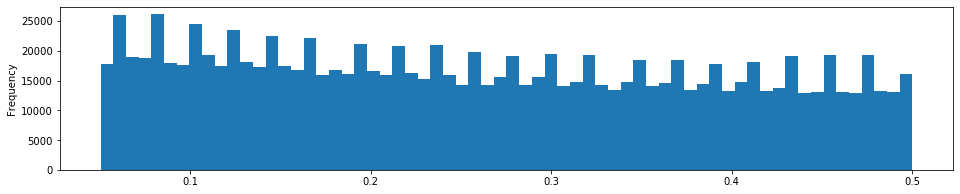

In [106]:
ax = pd.Series(hl.min(mt_qc3.variant_qc.AF).collect()).plot(kind='hist', bins=64, figsize=(16, 3), )

In [108]:
mt_qc3.write(osp.join(data_dir, 'HapMap_3_r3_8.mt'), overwrite=True)

2020-01-14 22:27:57 Hail: INFO: wrote matrix table with 1092657 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_8.mt


<h2><a id="step_4">Step 4: Hardy-Weinberg Equilibrium Filtering</a></h2>

In [131]:
mt_qc3 = hl.read_matrix_table(osp.join(data_dir, 'HapMap_3_r3_8.mt'))

In [132]:
%%timeop -o qc4

def good_variants(mt, threshold, use_founder_controls):
    if use_founder_controls:
        mt = mt.filter_cols(hl.is_missing(mt.pat_id) & hl.is_missing(mt.mat_id))
        # ~mt.iscase will be false if is_case is missing
        mt = mt.filter_cols(~mt.is_case)
    mt = mt.filter_rows(mt.variant_qc.p_value_hwe > threshold)
    return mt

def qc_4(mt):
    # This could be done by any of the following:
    # 1. Create an hl.set (must .collect() which is slow) containing the bad variant rsids and using mt.filter_rows
    # 2. Use hl.is_defined as a boolean expression to filter rows where one column in left join is missing
    #   - Ex: mt.filter_cols(hl.is_defined(related_samples_to_remove[mt.col_key]), keep=False)
    #   - See: https://hail.is/docs/0.2/methods/genetics.html#hail.methods.ld_prune
    # 3. Use semi_join (or anti_join to drop rather than preserve) intersecting keys (this is fastest by far)
    mt = mt.semi_join_rows(good_variants(mt, 1e-6, True).rows())
    mt = mt.semi_join_rows(good_variants(mt, 1e-10, False).rows())
    return mt

mt_qc4 = qc_4(mt_qc3)
print(mt_qc4.count())

(1092644, 165)
Elapsed time: 1.6 seconds


In [133]:
mt_qc4.write(osp.join(data_dir, 'HapMap_3_r3_9.mt'), overwrite=True)

2020-01-14 22:50:43 Hail: INFO: wrote matrix table with 1092644 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_9.mt


<h2><a id="step_5">Step 5: Heterozygosity Filtering</a></h2>

In [150]:
mt_qc4 = hl.read_matrix_table(osp.join(data_dir, 'HapMap_3_r3_9.mt'))

In [152]:
%%timeop -o qc5

def qc_5(mt):
    variants = hl.ld_prune(mt.GT, r2=0.2, bp_window_size=500000)
    mt = mt.filter_rows(hl.is_defined(variants[mt.row_key]))
    mt = mt.filter_rows((mt.locus.contig != "X") & (mt.locus.contig != "Y"))
    mt = mt.annotate_cols(het_rate=mt.sample_qc.n_het / mt.sample_qc.n_called)
    return mt, variants

mt_qc5, variants = qc_5(mt_qc4)
print(mt_qc5)

2020-01-14 23:08:39 Hail: INFO: ld_prune: running local pruning stage with max queue size of 729445 variants
2020-01-14 23:08:42 Hail: INFO: wrote table with 146145 rows in 16 partitions to file:/tmp/hail.PDC7aIyt1MRR/x0MAJ06eBS
2020-01-14 23:08:47 Hail: INFO: Wrote all 36 blocks of 146145 x 165 matrix with block size 4096.
2020-01-14 23:11:48 Hail: INFO: wrote table with 77 rows in 71 partitions to file:/tmp/hail.PDC7aIyt1MRR/PfTdEON0dL


Elapsed time: 188.7 seconds


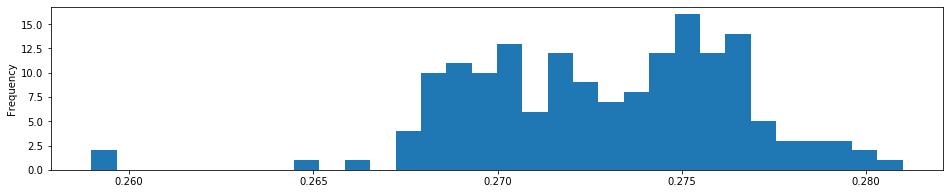

In [153]:
pd.Series(mt_qc5.het_rate.collect()).plot(kind='hist', bins=32, figsize=(16, 3))